### type A XGBoost 모델 학습 + SHAP

#### XGBoost

In [ ]:
import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("최최종데이터_a_지난주추가.csv", encoding = "cp949")
df = df.drop(columns=['week_start_date'])

# Columns for scaling

# caseA 돌릴 때 # 'last_flw_get',
columns = ['flw_get', 'height_pl', 'num_leaf', 'len_leaf',
           'width_leaf', 'unit_len', 'dim_pipe', 'temp_ex_max', 'temp_ex_min',
           'temp_ex_mean', 'temp_int_max', 'temp_int_min', 'temp_int_mean', 'sr_ex_max',
           'sr_ex_min', 'sr_ex_mean', 'hum_int_max', 'hum_int_min', 'hum_int_mean',
           'CO2_max', 'CO2_min', 'CO2_mean', 'soil_temp_max', 'soil_temp_min', 'soil_temp_mean']

# caseB 돌릴 때
# columns = ['week_sin','week_cos','flw_get','last_flw_get','height_pl','num_leaf','len_leaf','width_leaf','unit_len','dim_pipe',
#            'temp_ex_day','temp_ex_night','sr_ex_day','temp_int_day','temp_int_night','hum_int_day','hum_int_night',
#            'CO2_day','CO2_night','soil_temp_day','soil_temp_night']

# RobustScaler object
scaler = RobustScaler()

# Scale selected columns
df[columns] = scaler.fit_transform(df[columns])

# Separate independent and dependent variables
X = df.drop(columns=['flw_get'])  # Independent variables
y = df['flw_get']  # Dependent variable

# Group data by week
week_groups = df.groupby('week')

# Select data for training from week 4 to week 25
train_weeks = list(range(5, 26))
train_data = pd.concat([group for week, group in week_groups if week in train_weeks])

# Select data for testing from week 26 to week 30
test_weeks = list(range(26, 31))
test_data = pd.concat([group for week, group in week_groups if week in test_weeks])

# Separate independent and dependent variables for training and testing
X_train = train_data.drop(columns=['flw_get', 'id', 'week', 'obj_num', 'last_flw_get'])  # Independent variables
y_train = train_data['flw_get']  # Dependent variable
X_test = test_data.drop(columns=['flw_get', 'id', 'week', 'obj_num', 'last_flw_get'])  # Independent variables
y_test = test_data['flw_get']  # Dependent variable

xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                                 colsample_bytree=1, max_depth=7)
# print(len(X_train), len(X_test))

xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.08, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Best Parameters: {'gamma': 0.01, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 1000, 'subsample': 0.8}
MSE (Best Model): 0.7794740939493959


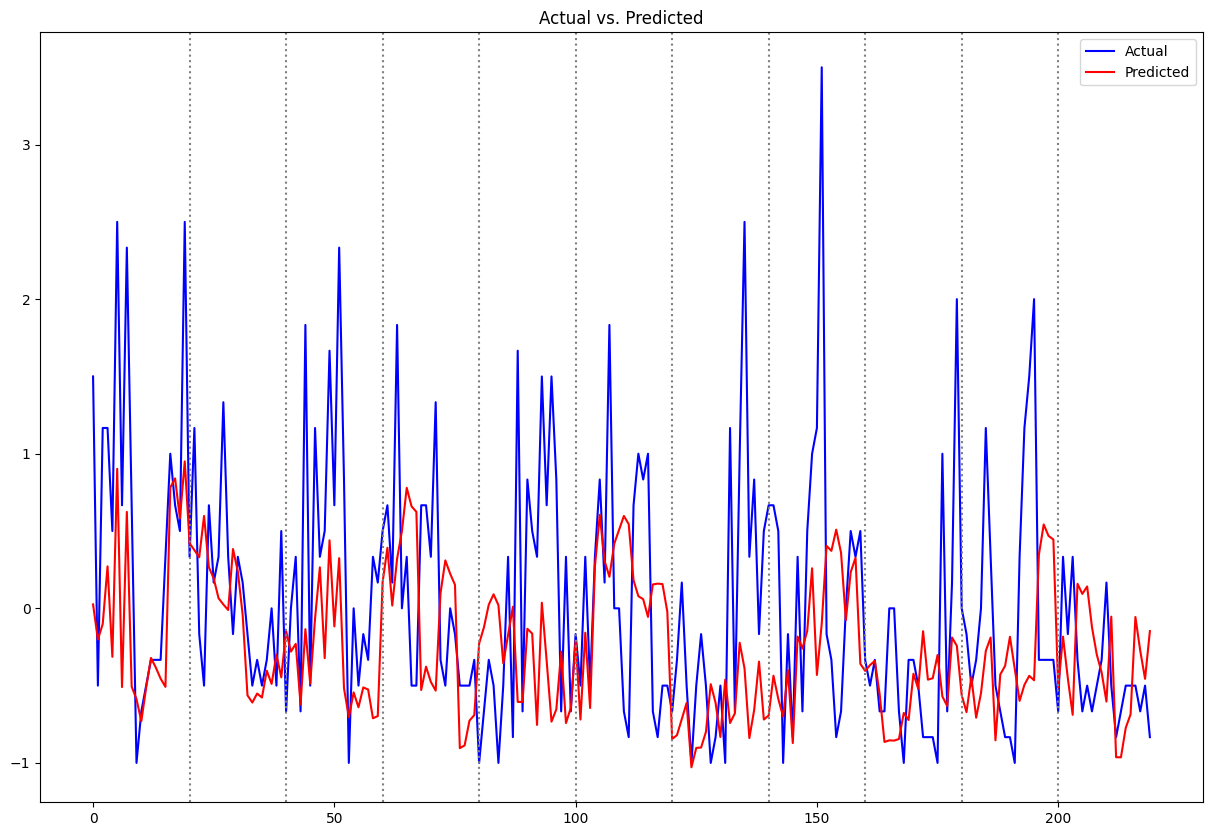

In [ ]:
# 하이퍼파라미터 그리드 설정 >> 새로 지정해준 값들
param_grid = {
    'n_estimators': [1000],
    'max_depth': [6],
    'learning_rate': [0.03],
    'subsample': [0.8],
    'gamma': [0.01],
    'min_child_weight': [5]
}

# GridSearchCV 생성
grid_search = GridSearchCV(
    estimator=xgboost.XGBRegressor(random_state=100, n_jobs=-1),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3
)

# 그리드 서치를 사용하여 최적의 모델 훈련
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Parameters:", grid_search.best_params_)

# 최적의 모델 얻기
best_model = grid_search.best_estimator_

# 최적의 모델로 예측
y_pred = best_model.predict(X_test)

# 최적의 모델로 평가 지표 계산
mse = mean_squared_error(y_test, y_pred)
print(f"MSE (Best Model): {mse}")

# 예측 결과 시각화
plt.figure(figsize=(15, 10))
plt.plot(range(len(y_test)), y_test, color='blue', label='Actual')
plt.plot(range(len(y_pred)), y_pred, color='red', label='Predicted')
for i in range(1, 11):
    plt.axvline(x=20*i, linestyle='dotted', color='gray')
plt.title("Actual vs. Predicted")
plt.legend()
plt.show()

In [ ]:
# 일단 XAI 설치 하시고요
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 8.4 MB/s eta 0:00:00


In [ ]:
import shap

# shap_values 계산을 위한 masker 생성
masker = shap.maskers.Independent(data=X_train.values)

# shap.Explainer에 masker 전달
explainer = shap.Explainer(xgb_model, masker)

# shap_values 계산
shap_values = explainer.shap_values(X_test.values)

[05:02:17] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


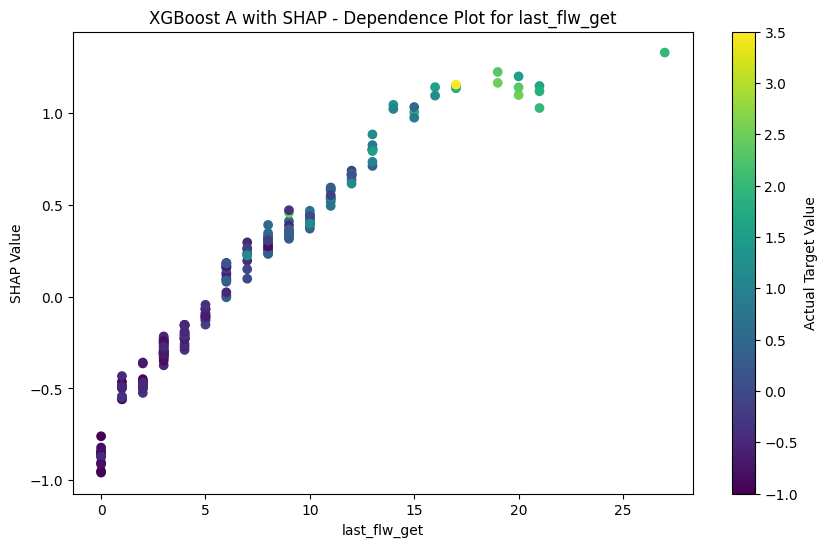

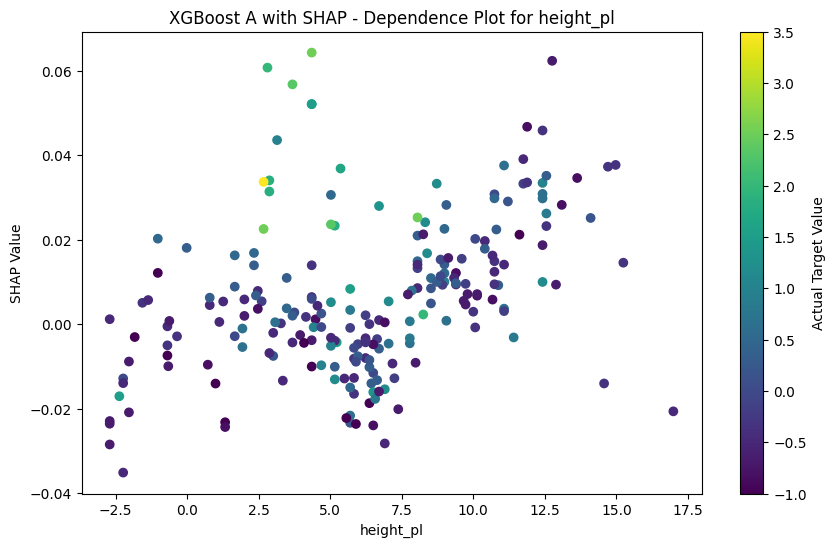

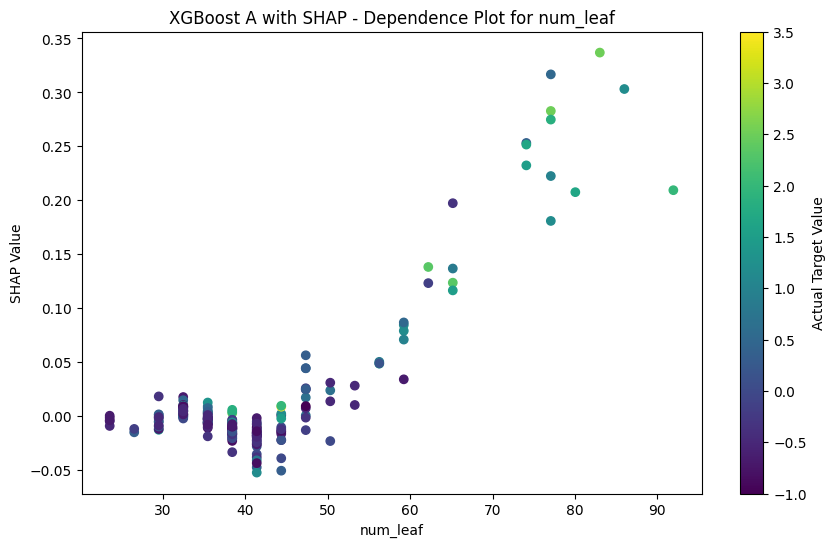

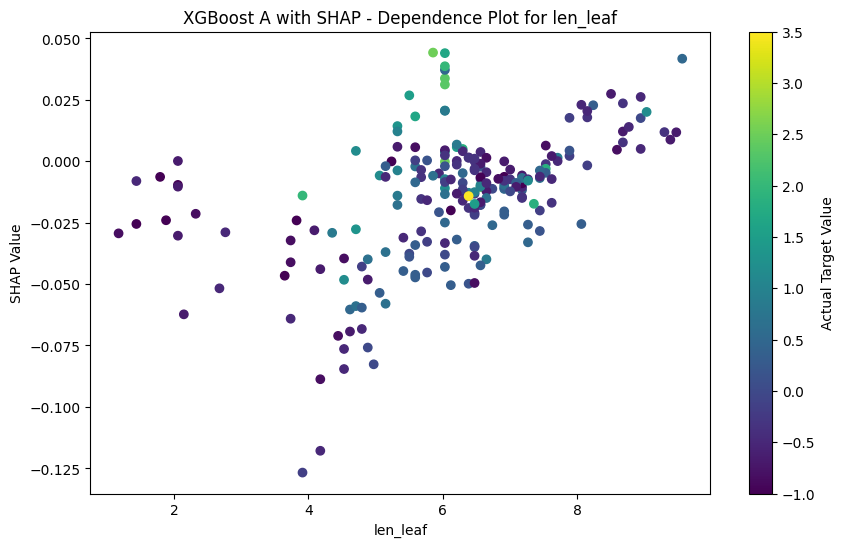

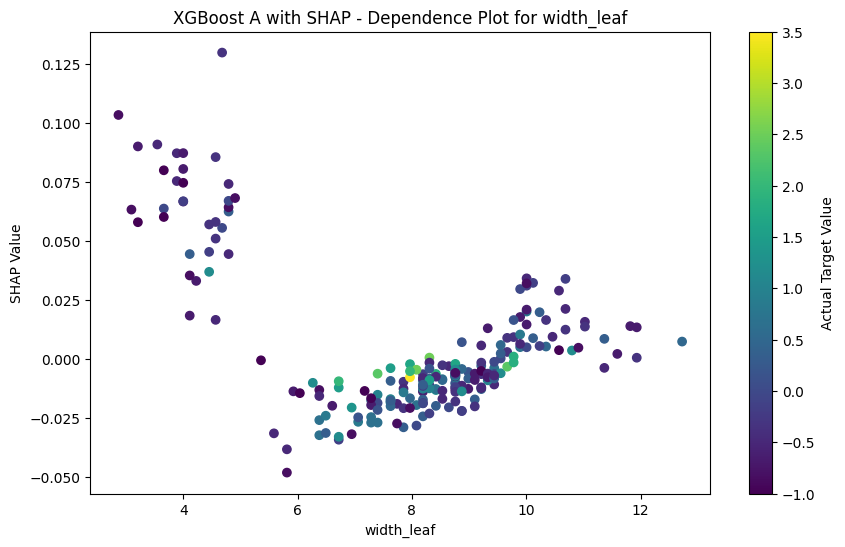

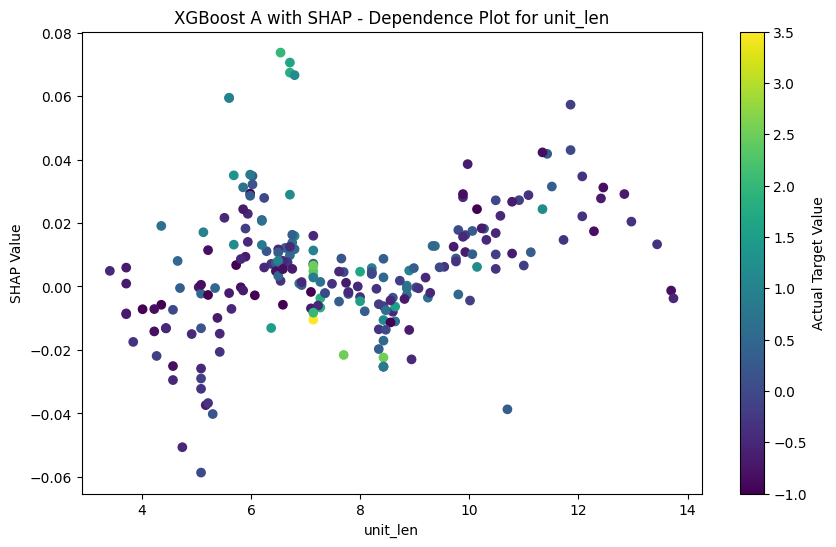

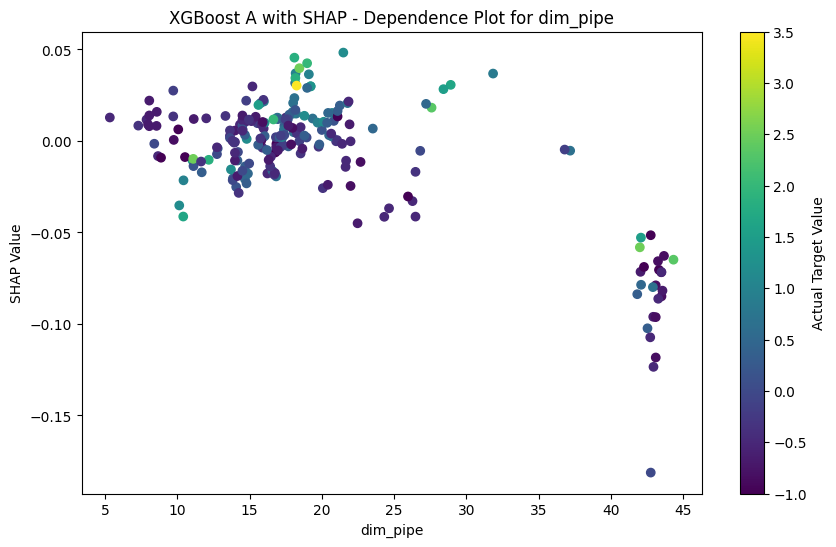

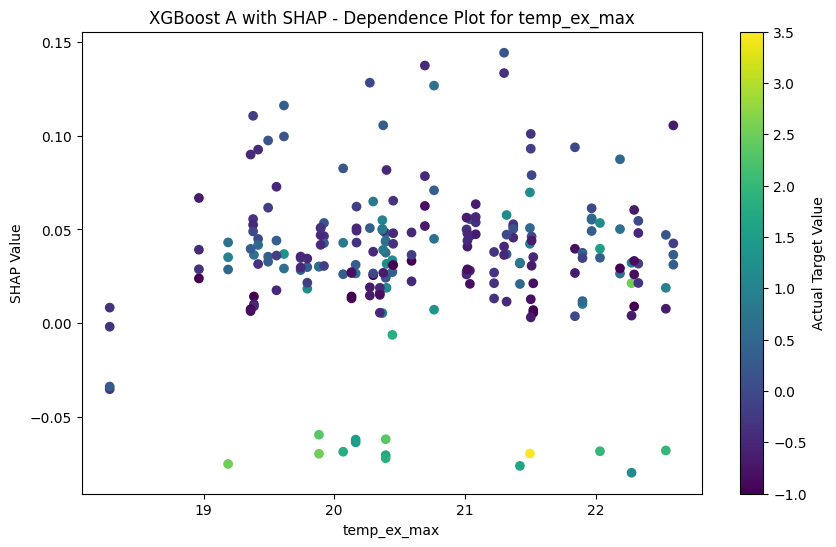

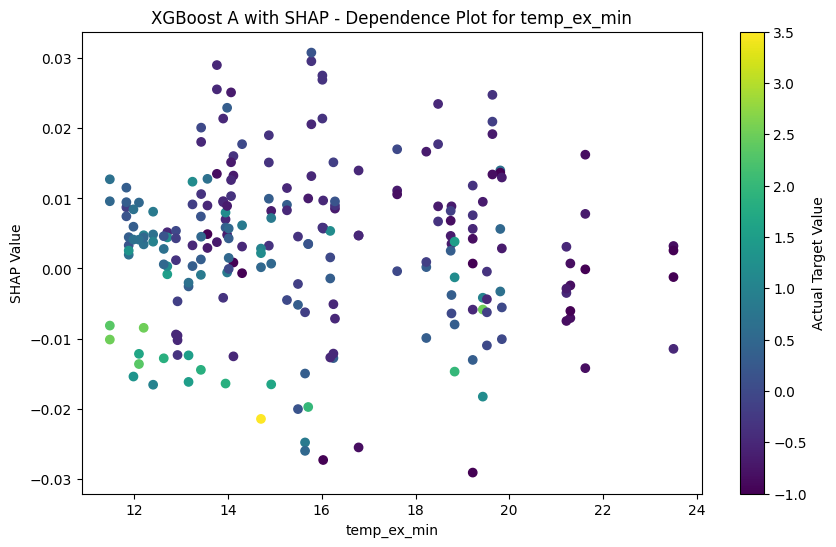

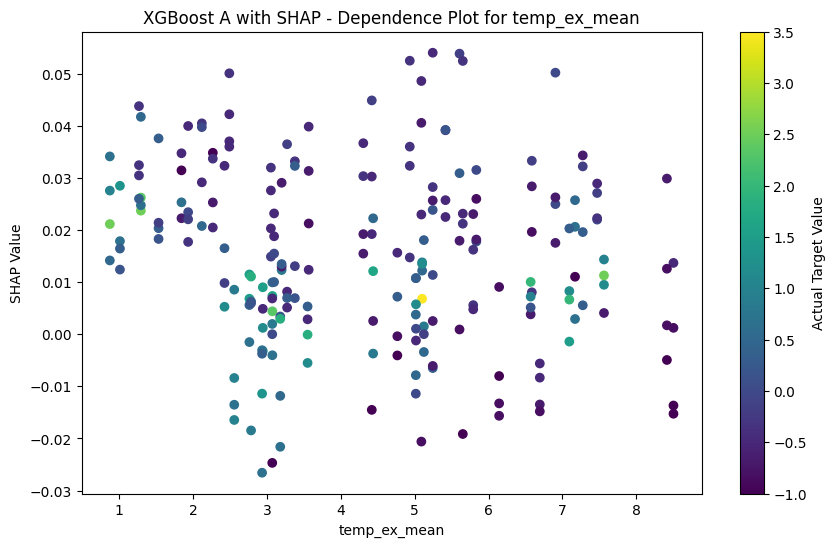

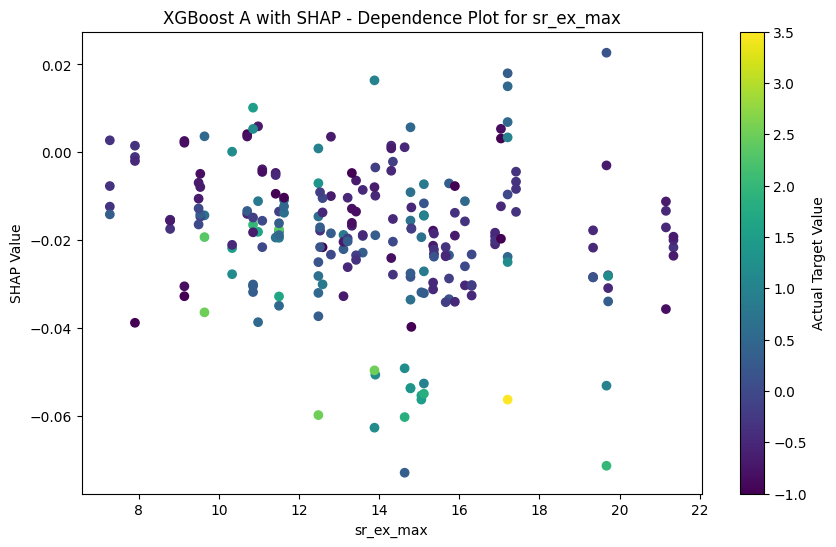

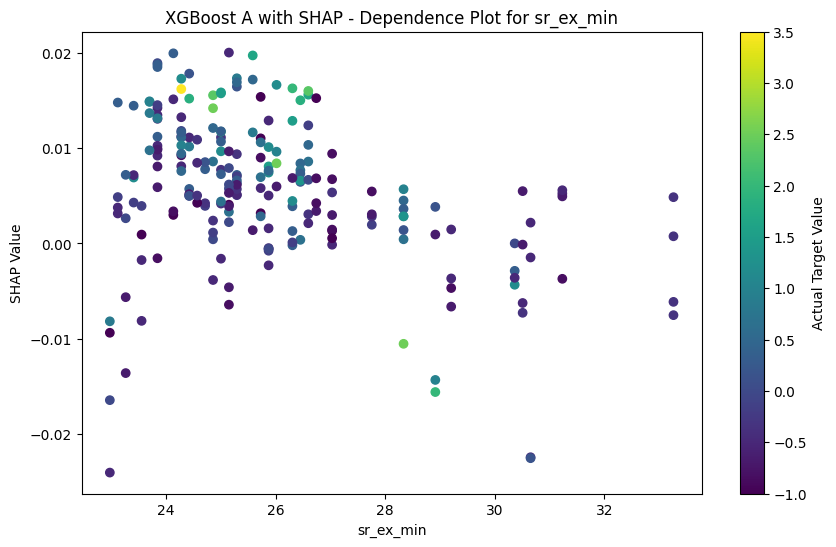

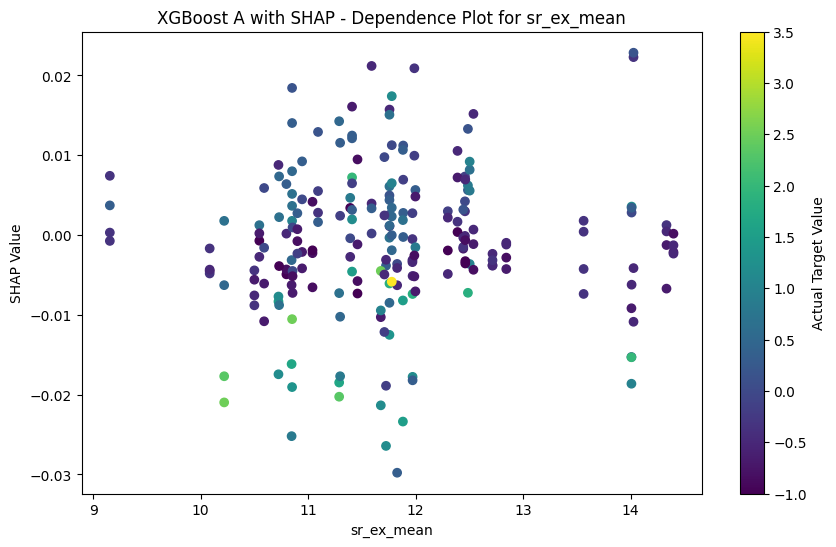

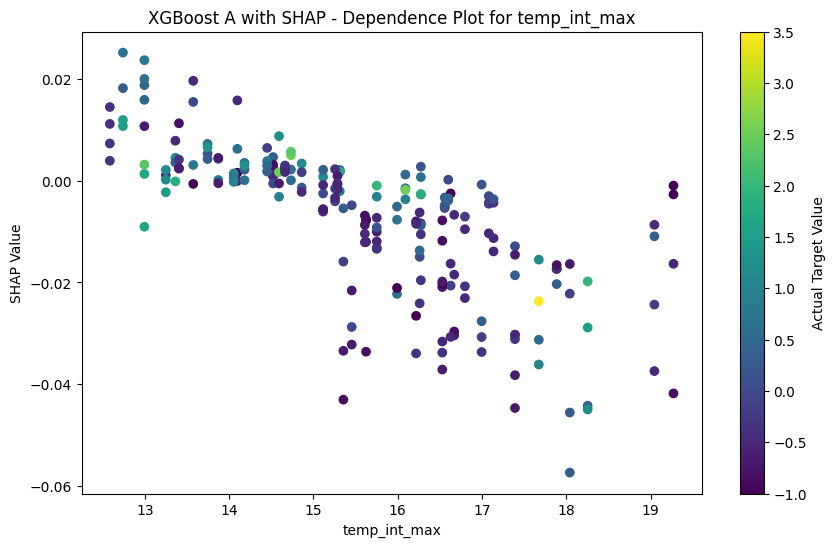

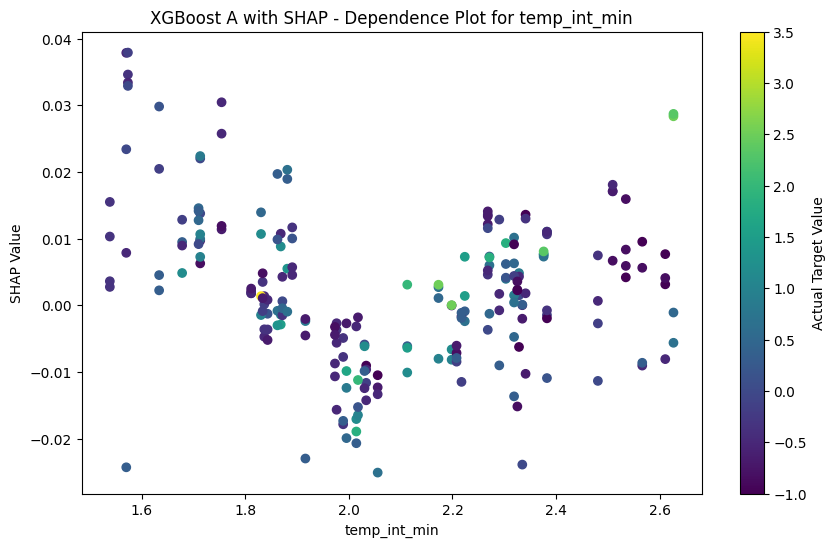

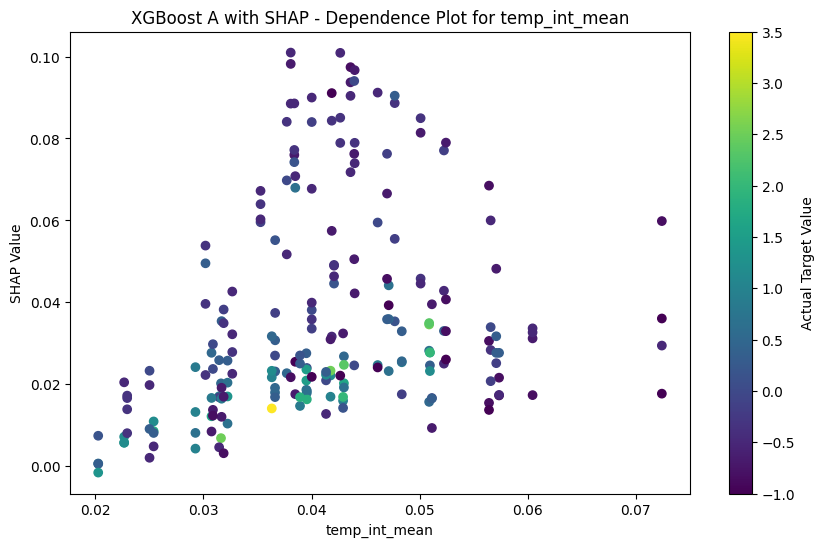

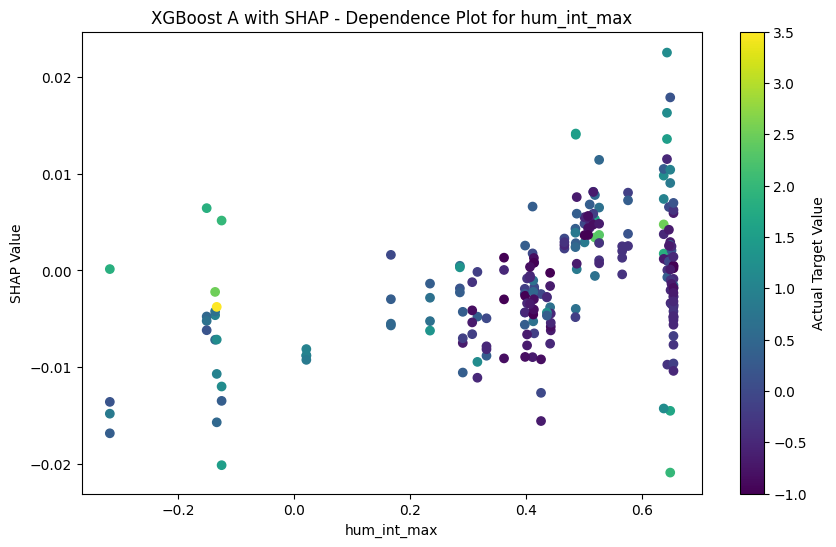

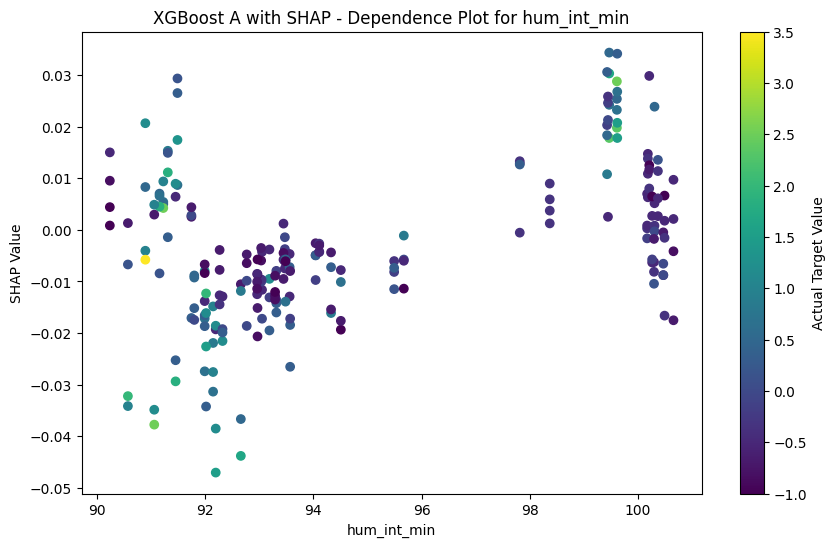

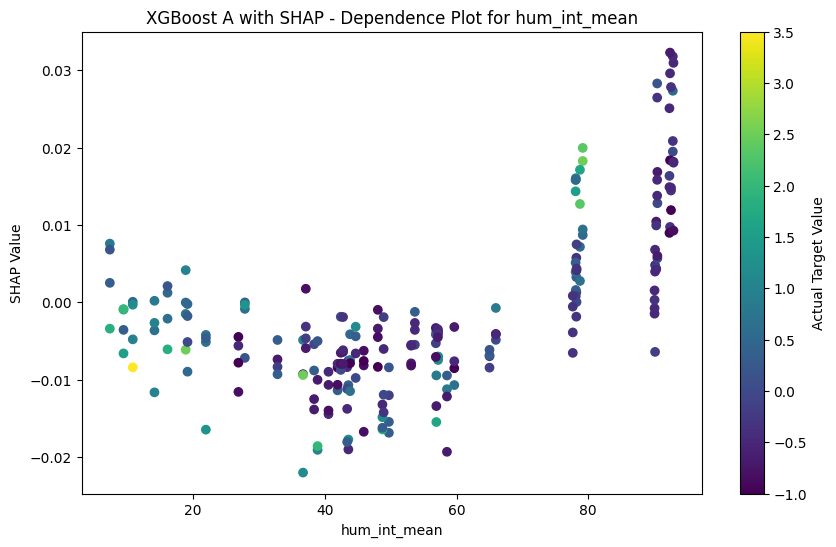

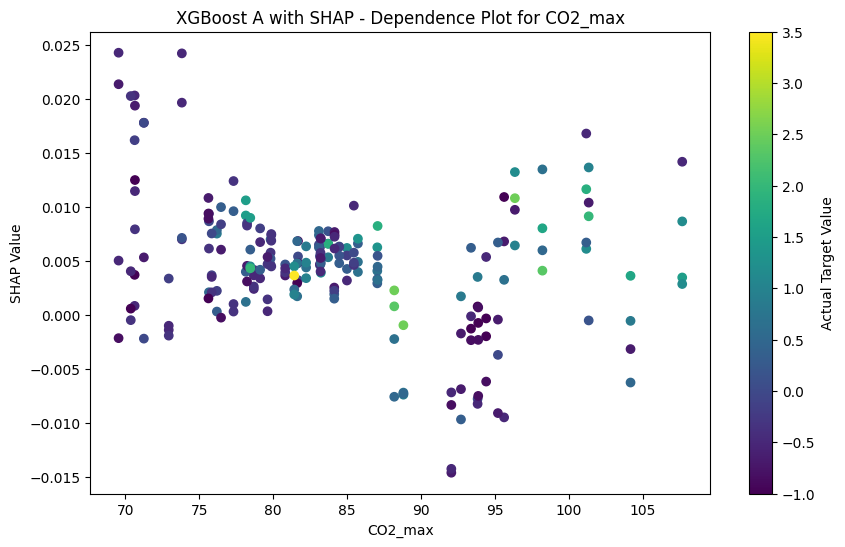

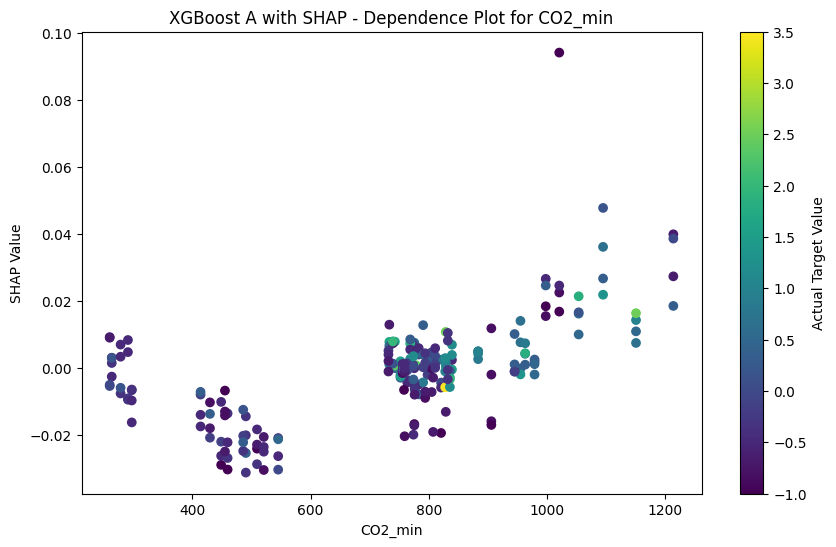

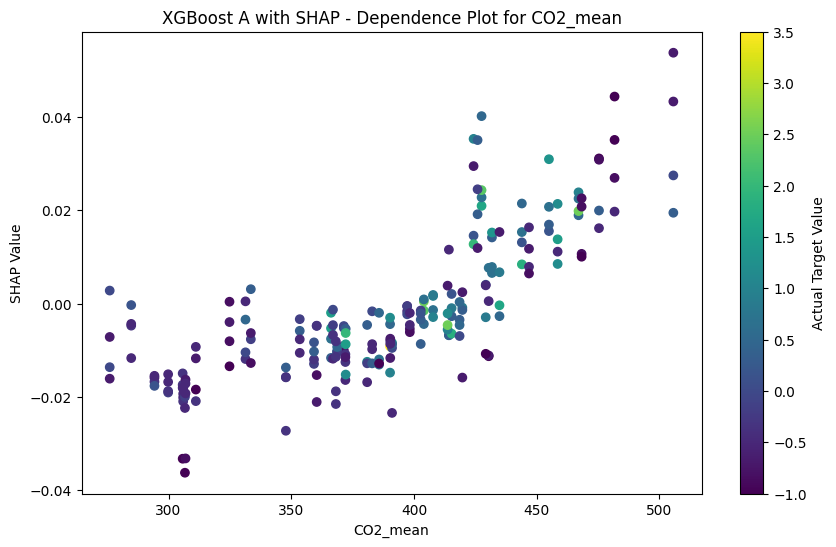

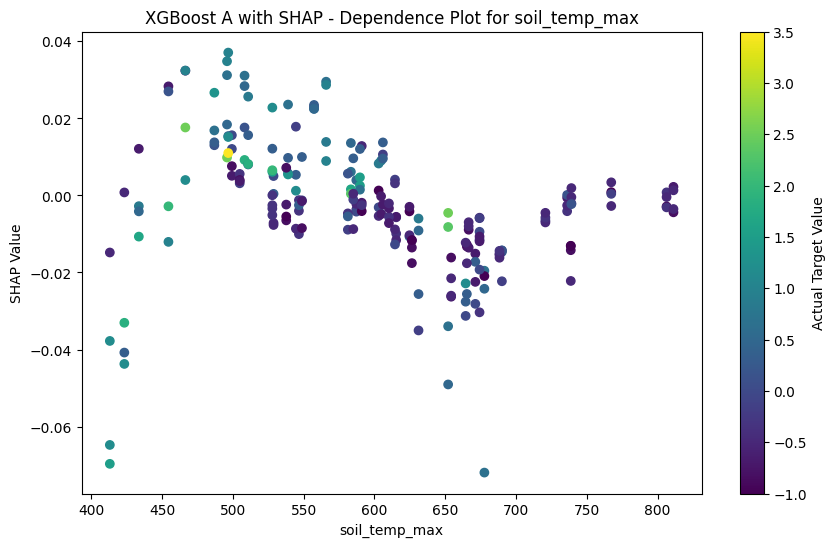

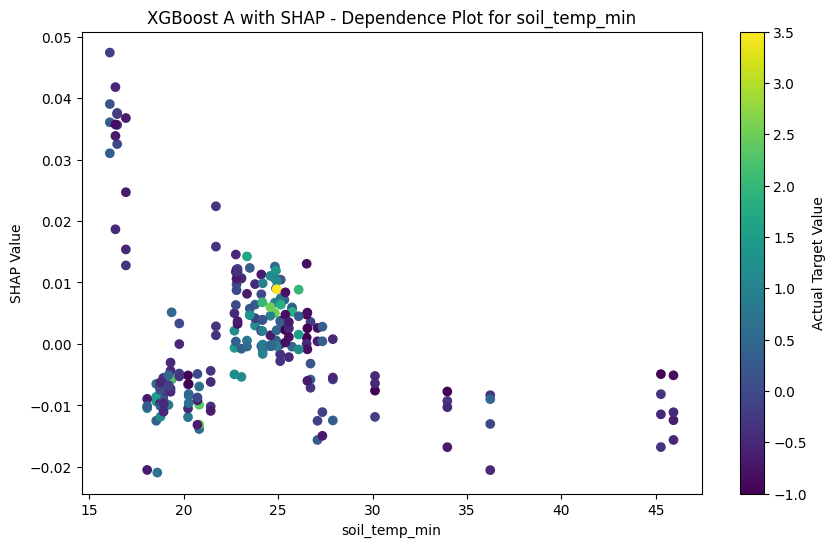

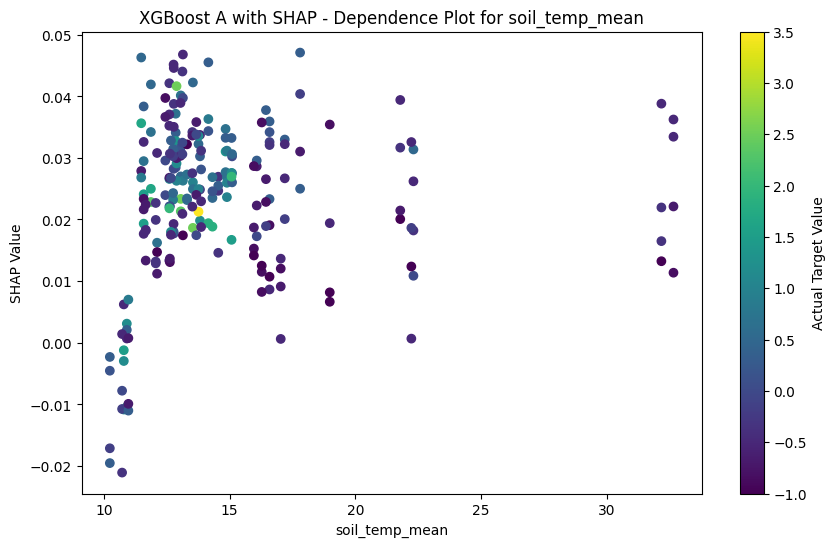

In [ ]:
for selected_feature_name in X_test.columns :
  # 선택한 특성의 이름
  selected_feature_index = X_test.columns.get_loc(selected_feature_name)

  # RobustScaler의 중앙값과 IQR 이용
  center = scaler.center_[df.columns.get_loc(selected_feature_name)-4]
  scale = scaler.scale_[df.columns.get_loc(selected_feature_name)-4]

  # 스케일링된 데이터를 원래 값으로 역변환
  feature_values_original = X_test[selected_feature_name].values * scale + center

  # dependence plot 그리기
  plt.figure(figsize=(10, 6))

  plt.scatter(feature_values_original, shap_values[:, selected_feature_index], c=y_test)
  plt.xlabel(selected_feature_name)
  plt.ylabel('SHAP Value')
  plt.title(f'XGBoost A with SHAP - Dependence Plot for {selected_feature_name}')
  plt.colorbar(label='Actual Target Value')
  plt.savefig(f"{selected_feature_name}_dependence_plot_original.png")
  plt.show()

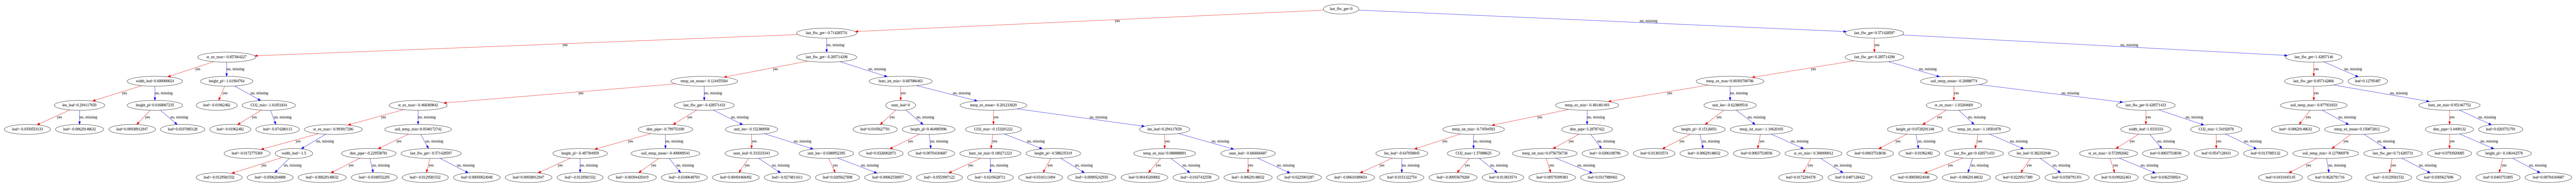

In [ ]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 100, 200
plot_tree(xgb_model)
plt.show()

[12:35:23] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


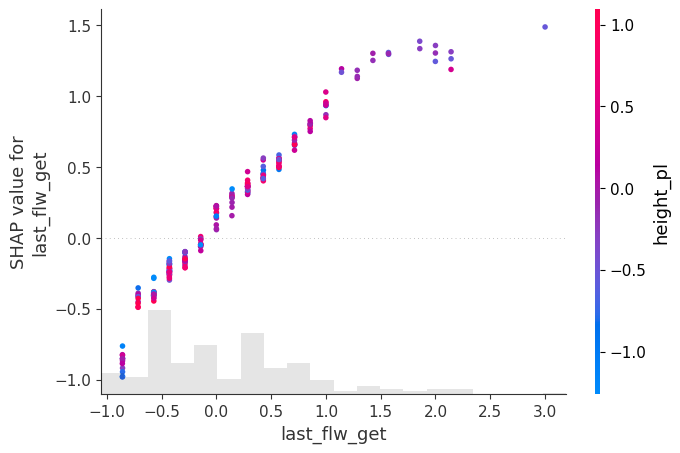

In [ ]:
import shap

# 모델 설명자 생성
explainer = shap.Explainer(xgb_model)

# SHAP 값 계산
shap_values = explainer(X_test)

shap.plots.scatter(shap_values[:,0], color=shap_values[:,1])

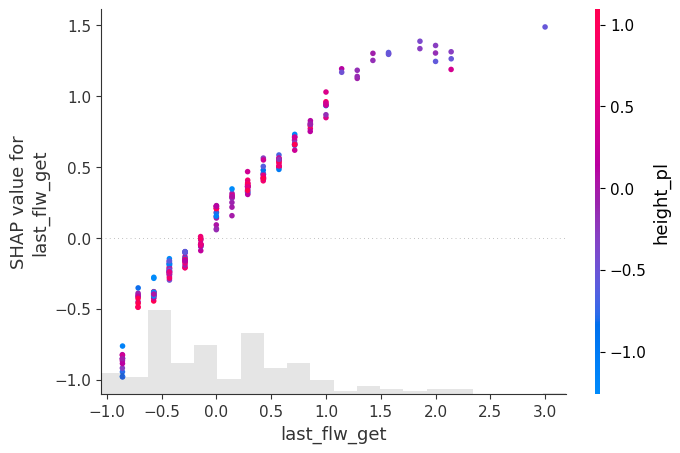

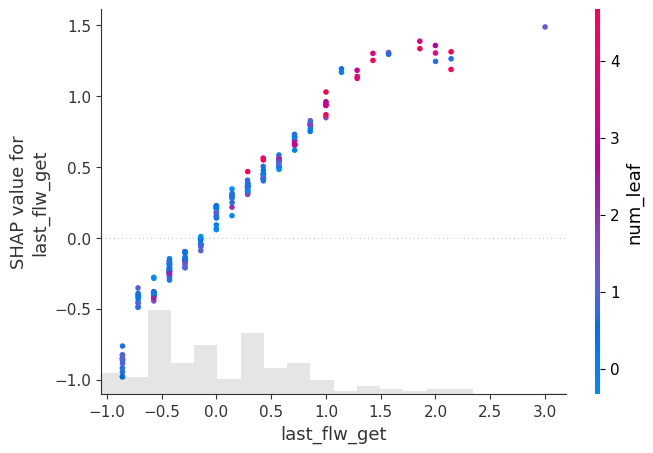

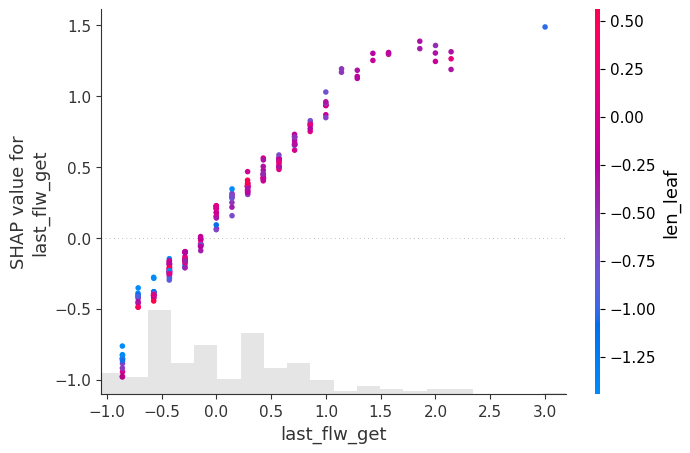

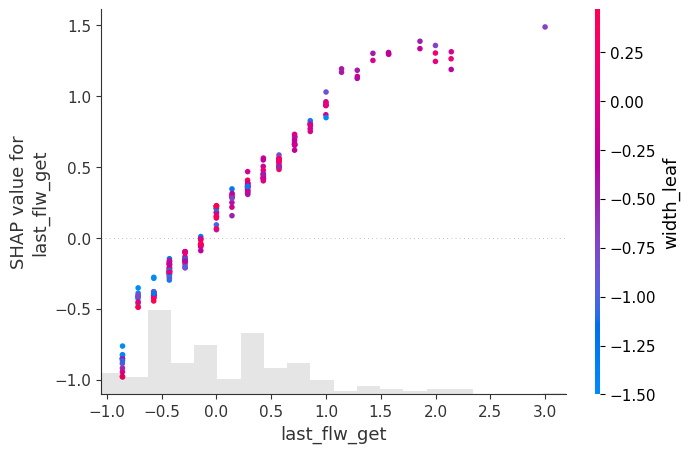

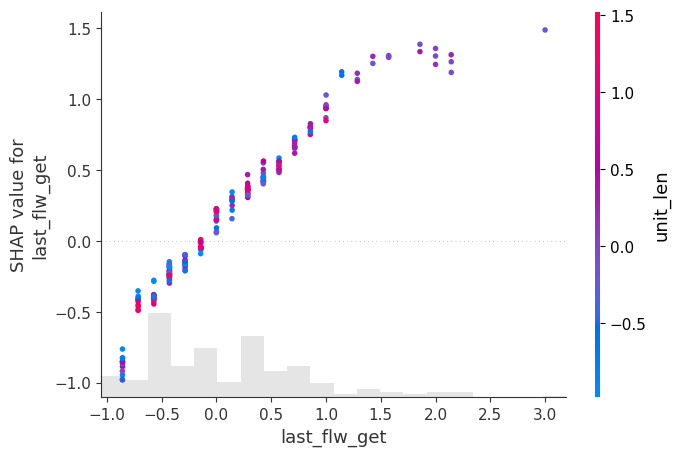

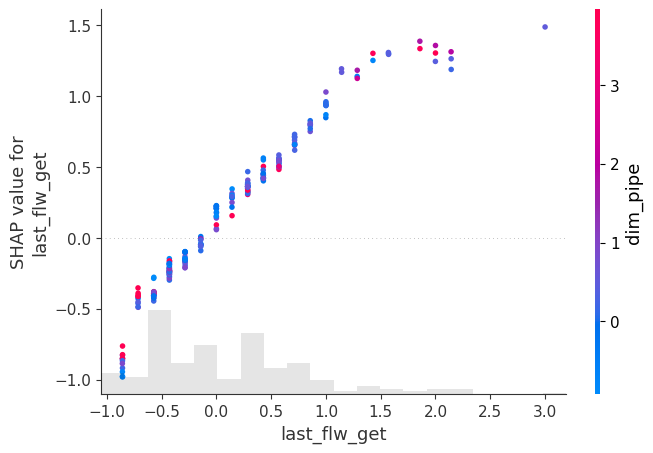

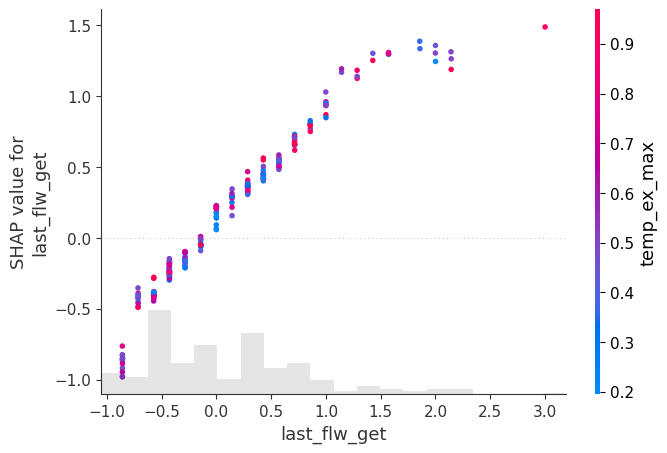

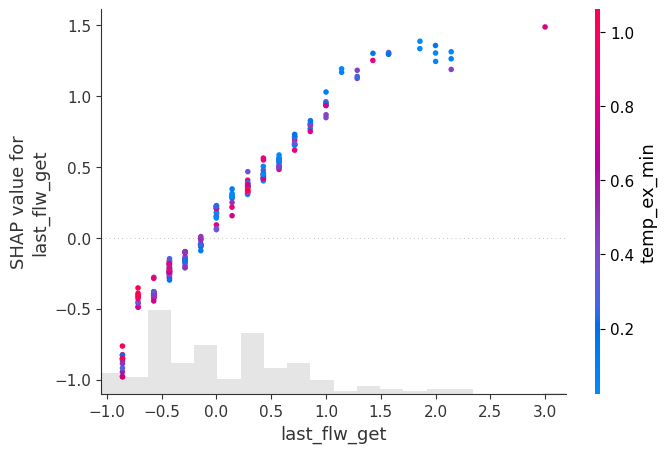

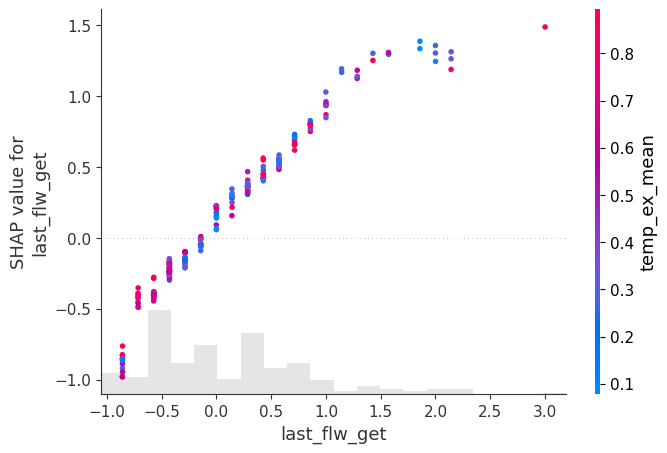

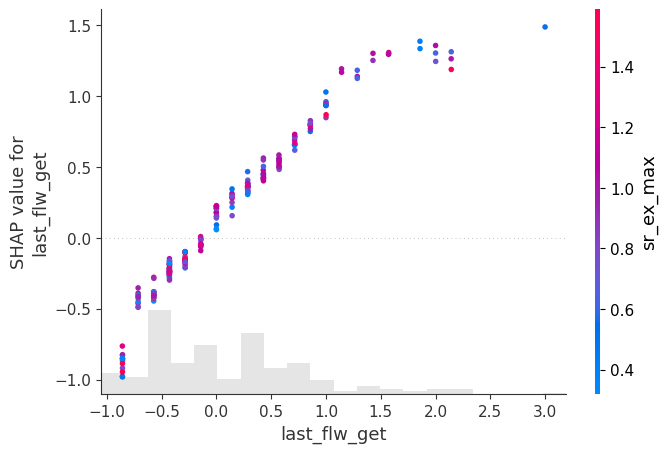

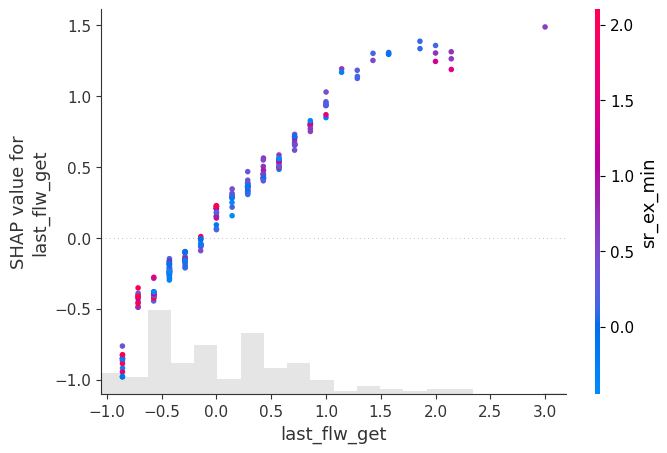

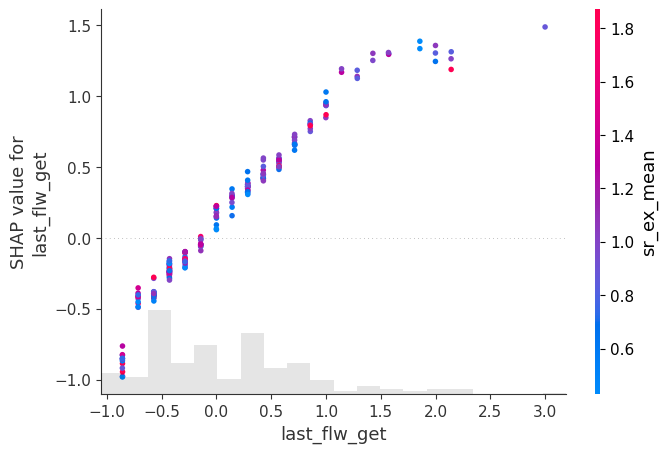

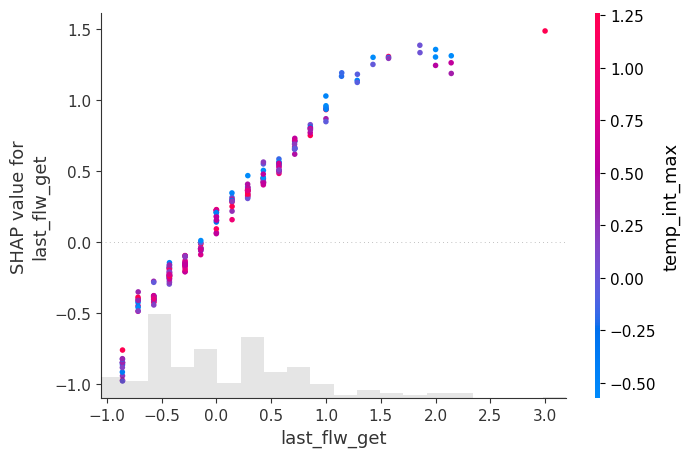

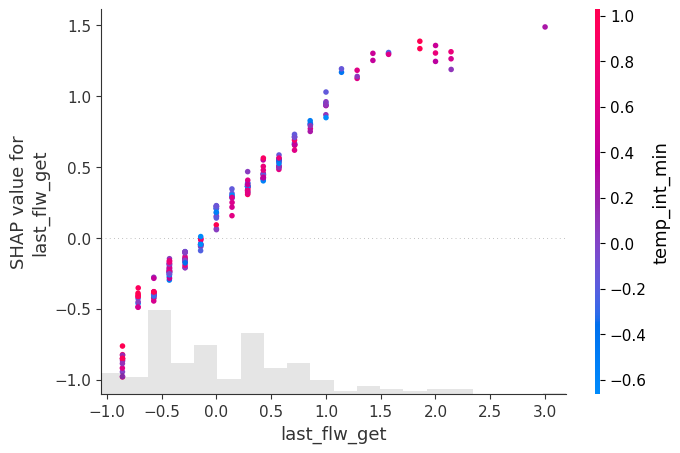

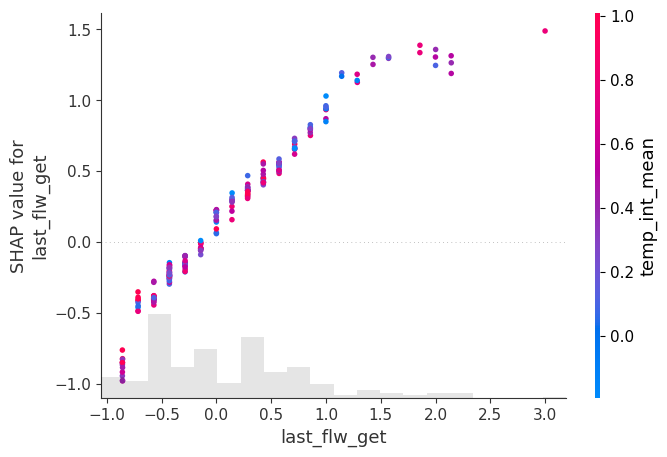

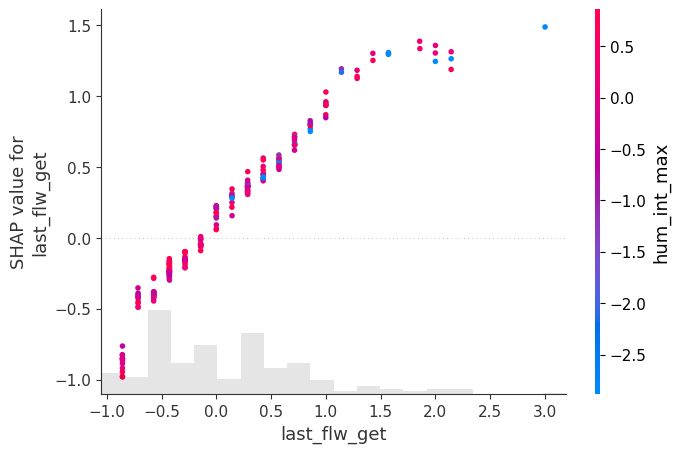

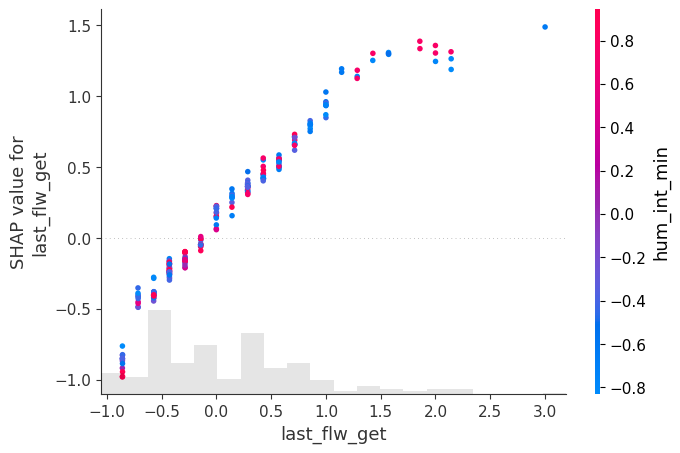

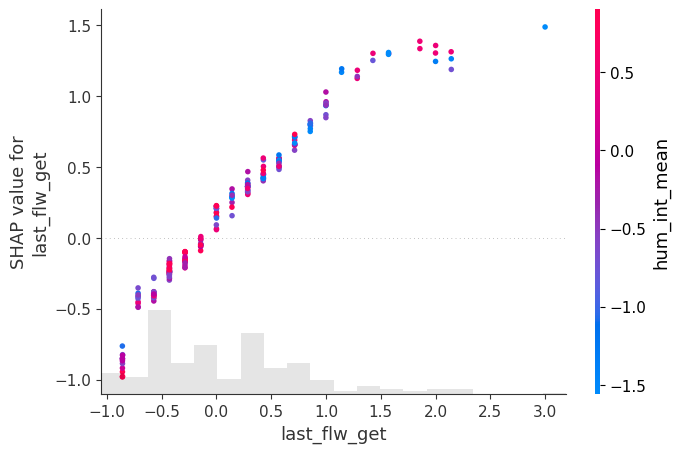

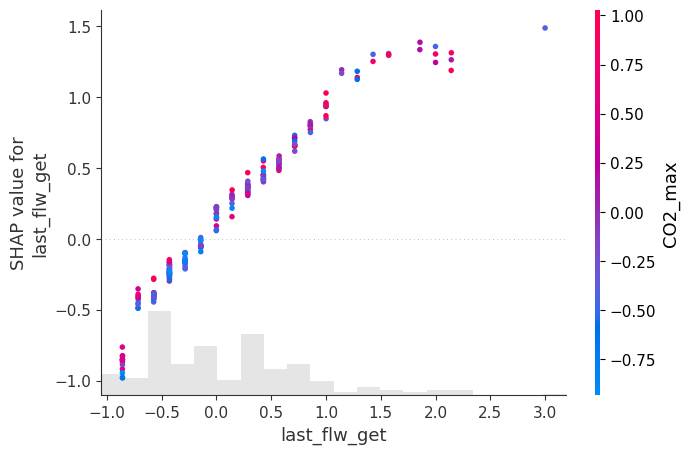

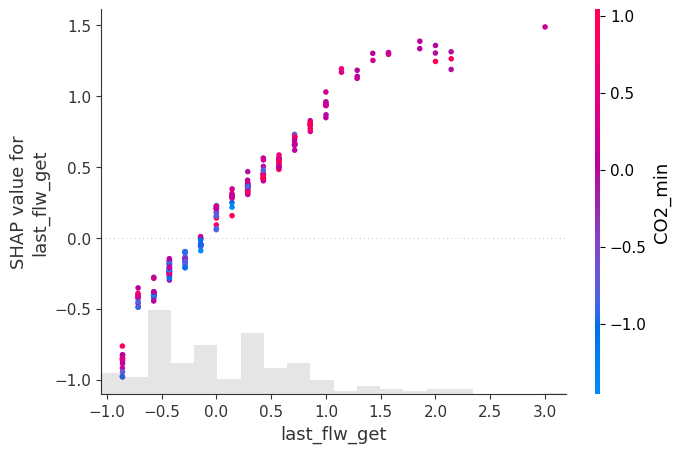

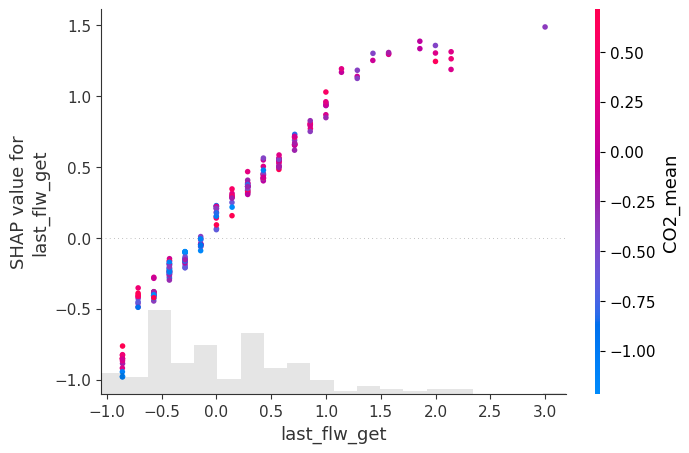

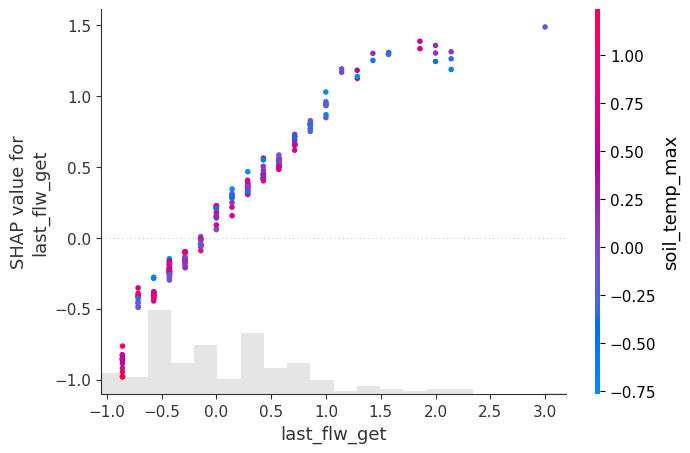

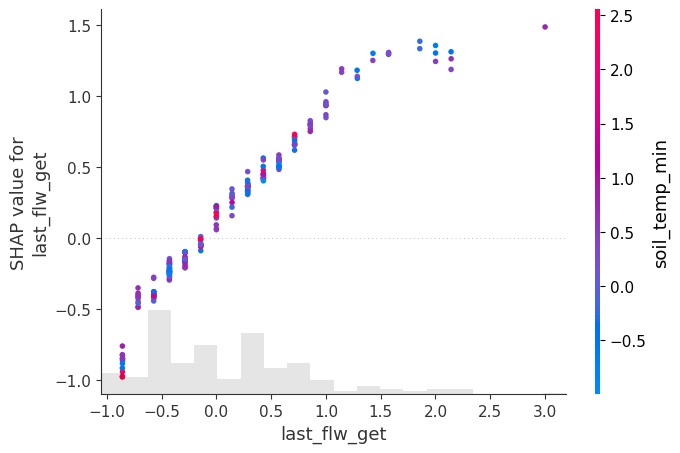

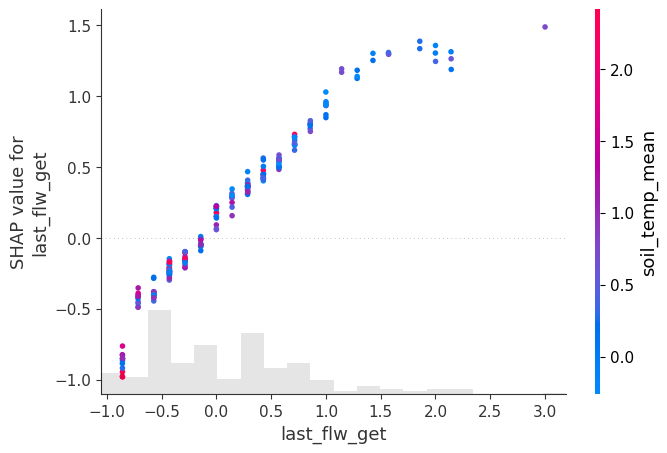

In [ ]:
for i in range(1, shap_values.shape[1]) :
  shap.plots.scatter(shap_values[:,0], color=shap_values[:,i])

[05:04:10] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[05:04:11] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


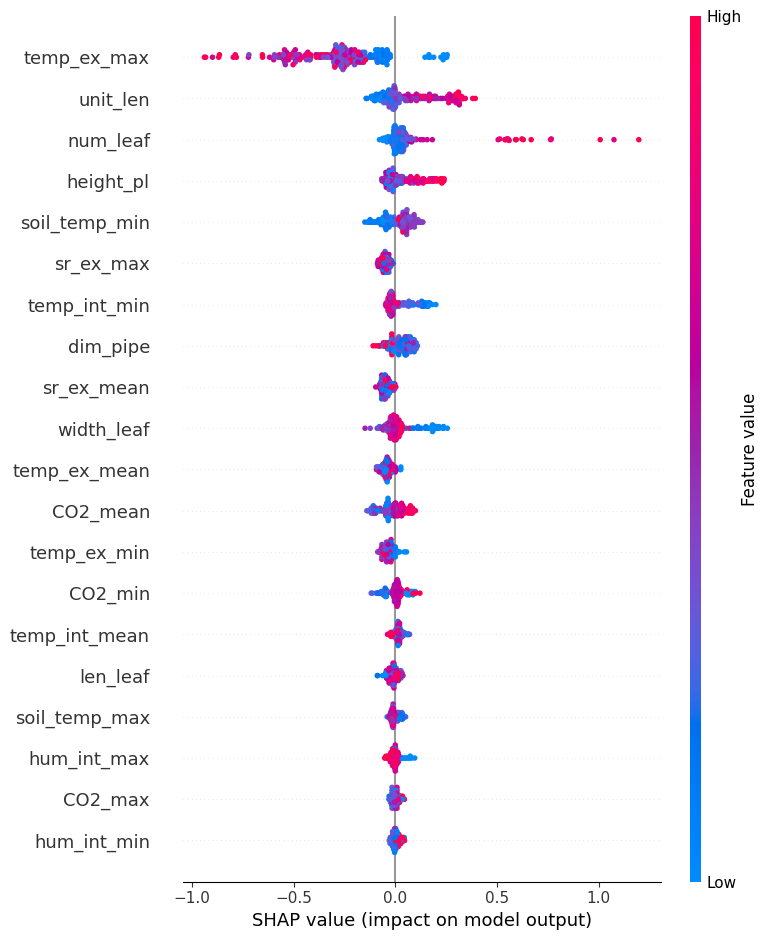

In [ ]:
# 돌려주세욥
import shap

# 모델 설명자 생성
explainer = shap.Explainer(xgb_model)

# SHAP 값 계산
shap_values = explainer.shap_values(X_test)

# 특성 중요도 시각화
shap.summary_plot(shap_values, X_test)

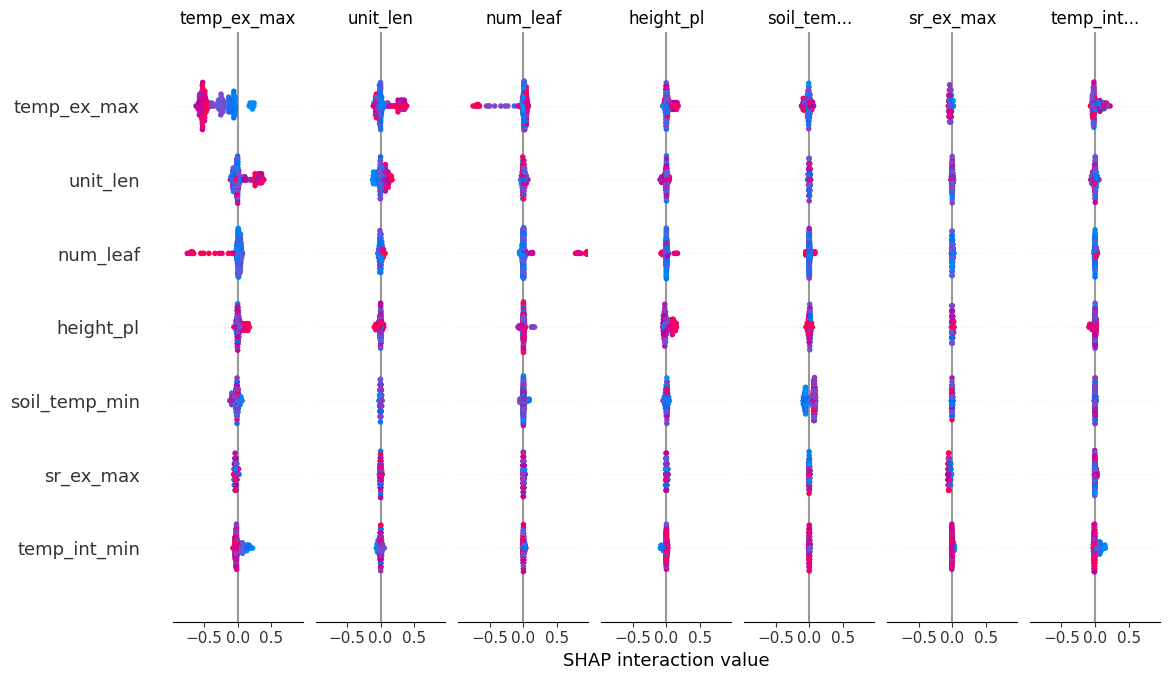

In [ ]:
shap_interaction_values = explainer.shap_interaction_values(X_test)

shap.summary_plot(shap_interaction_values, X_test)

In [ ]:
X_test

last_flw_get  height_pl  num_leaf  len_leaf  width_leaf  unit_len  \
84        0.714286  -0.128852  4.666667 -0.323529   -0.100000 -0.309524   
85        0.142857  -1.372549 -1.000000 -1.441176   -1.266667 -1.195238   
86        0.714286   0.173669  3.000000 -0.323529   -0.200000 -0.166667   
87        1.000000   0.453782  6.000000 -0.764706   -0.833333 -0.195238   
188       0.714286  -0.722689  1.000000 -0.794118    0.033333 -0.195238   
...            ...        ...       ...       ...         ...       ...   
1039     -0.428571   0.789916  0.333333  0.147059    0.100000  0.104762   
1140     -0.714286  -0.812325  1.000000 -1.852941   -1.633333 -0.952381   
1141     -0.714286   0.229692  0.333333 -0.941176   -0.733333 -0.638095   
1142     -0.714286  -0.521008  0.000000 -0.294118   -0.166667 -0.123810   
1143     -0.857143   0.084034  1.000000 -1.558824   -1.466667 -1.023810   

      dim_pipe  temp_ex_max  temp_ex_min  temp_ex_mean  ...  temp_int_mean  \
84   -0.617093     0.493701     0.112963      0.294680  ...      -0.206389   
85   -1.071274     0.493701     0.112963      0.294680  ...      -0.206389   
86    0.219685     0.493701     0.112963      0.294680  ...      -0.206389   
87    0.873804     0.493701     0.112963      0.294680  ...      -0.206389   
188   1.165073     0.366142    -0.022222      0.080770  ...       0.780751   
...        ...          ...          ...           ...  ...            ...   
1039  1.278618     0.646457     0.562963      0.572804  ...       0.332711   
1140  4.018513     0.481102     1.051852      0.780618  ...       1.115536   
1141  4.028386     0.481102     1.051852      0.780618  ...       1.115536   
1142  3.986424     0.481102     1.051852      0.780618  ...       1.115536   
1143  4.043197     0.481102     1.051852      0.780618  ...       1.115536   

      hum_int_max  hum_int_min  hum_int_mean   CO2_max   CO2_min  CO2_mean  \
84       0.803407    -0.591562     -0.164030  1.428822  0.258384  0.533908   
85       0.803407    -0.591562     -0.164030  1.428822  0.258384  0.533908   
86       0.803407    -0.591562     -0.164030  1.428822  0.258384  0.533908   
87       0.803407    -0.591562     -0.164030  1.428822  0.258384  0.533908   
188      0.249581     0.784084      0.497636  0.186597  0.070884 -0.047733   
...           ...          ...           ...       ...       ...       ...   
1039     0.856405     0.978146      0.912577 -1.002628 -0.717226 -1.083942   
1140    -0.314844    -0.449565     -0.665227  0.432764  0.012957  0.409414   
1141    -0.314844    -0.449565     -0.665227  0.432764  0.012957  0.409414   
1142    -0.314844    -0.449565     -0.665227  0.432764  0.012957  0.409414   
1143    -0.314844    -0.449565     -0.665227  0.432764  0.012957  0.409414   

      soil_temp_max  soil_temp_min  soil_temp_mean  
84        -0.890767       0.117940       -0.263889  
85        -0.890767       0.117940       -0.263889  
86        -0.890767       0.117940       -0.263889  
87        -0.890767       0.117940       -0.263889  
188        0.546782      -0.217608        0.263030  
...             ...            ...             ...  
1039       1.504293       4.297342        4.820876  
1140       0.559617       0.636213        1.187810  
1141       0.559617       0.636213        1.187810  
1142       0.559617       0.636213        1.187810  
1143       0.559617       0.636213        1.187810  

[220 rows x 25 columns]

In [ ]:
X_test.iloc[:,0]

84      0.714286
85      0.142857
86      0.714286
87      1.000000
188     0.714286
          ...   
1039   -0.428571
1140   -0.714286
1141   -0.714286
1142   -0.714286
1143   -0.857143
Name: last_flw_get, Length: 220, dtype: float64

In [ ]:
shap_values.shape

(220, 25)